# Notebook 4 : Hybrid Recommendation System

## Objectifs de ce notebook

Dans ce notebook, nous allons :

1. Comprendre le concept des systèmes hybrides
2. Charger les modèles des Notebooks 2 et 3
3. Combiner les prédictions Collaborative et Content-Based
4. Tester différentes stratégies de combinaison (pondération)
5. Comparer les résultats avec les approches individuelles

---

## Qu'est-ce qu'un Système Hybride ?

Un système hybride **combine plusieurs approches** de recommandation pour profiter des avantages de chacune.

### Avantages de l'approche hybride :

- **Meilleure précision** : Combine les forces de chaque méthode
- **Réduit le cold start** : Content-Based aide pour les nouveaux films
- **Plus de diversité** : Collaborative apporte de la découverte
- **Plus robuste** : Si une approche échoue, l'autre compense

### Stratégies de combinaison :

1. **Weighted (Pondération)** : Score final = α × Collaborative + β × Content-Based
2. **Switching** : Choisir l'une ou l'autre selon le contexte
3. **Mixed** : Présenter des résultats des deux approches
4. **Feature Combination** : Utiliser les deux comme features d'un modèle ML

Aujourd'hui, on va utiliser la stratégie **Weighted** (pondération).

---

In [2]:
# Librairies pour manipulation de données
import pandas as pd
import numpy as np

# Librairies pour visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Librairies pour charger les modèles
import pickle

# Configuration des graphiques
plt.style.use('ggplot')
sns.set_palette('husl')
%matplotlib inline

# Affichage pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Librairies importées avec succès")

Librairies importées avec succès


## 2. Chargement des Données et Modèles

Nous chargeons :
- Les données nettoyées (ratings, movies)
- Le modèle SVD (Collaborative Filtering)
- La matrice de similarité cosine (Content-Based Filtering)

In [3]:
# Chargement des données
ratings = pd.read_csv('../data/processed/ratings_clean.csv')
movies = pd.read_csv('../data/processed/movies_clean.csv')

print("Données chargées :")
print(f"- Ratings : {len(ratings):,} lignes")
print(f"- Films : {len(movies):,} lignes")

Données chargées :
- Ratings : 100,000 lignes
- Films : 1,682 lignes


In [4]:
with open('../models/svd_model.pkl', 'rb') as f:
    svd_model = pickle.load(f)
print("Modèle SVD chargé avec succès")


Modèle SVD chargé avec succès


In [5]:
with open('../models/cosine_sim_matrix.pkl', 'rb') as f:
        cosine_sim = pickle.load(f)
print(f"Matrice de similarité chargée avec succès")
print(f"Dimensions : {cosine_sim.shape}")

Matrice de similarité chargée avec succès
Dimensions : (1682, 1682)


## 3. Fonctions de Recommandation Individuelles

Avant de combiner les approches, on va créer des fonctions pour obtenir les scores de chacune séparément.

Ces fonctions retourneront un DataFrame avec :
- `item_id` : ID du film
- `score` : Score de recommandation (collaborative_score ou content_score)

In [6]:
def get_collaborative_scores(user_id, svd_model, ratings_df, movies_df):
    """
    Calcule les scores Collaborative Filtering pour tous les films non vus
    
    Paramètres :
    - user_id : ID de l'utilisateur
    - svd_model : Modèle SVD entraîné
    - ratings_df : DataFrame des ratings
    - movies_df : DataFrame des films
    
    Retourne : DataFrame avec item_id et collaborative_score
    """
    # Films déjà notés
    user_ratings = ratings_df[ratings_df['user_id'] == user_id]
    rated_items = user_ratings['item_id'].tolist()
    
    # Tous les films
    all_items = movies_df['item_id'].tolist()
    
    # Films non notés
    items_to_predict = [item for item in all_items if item not in rated_items]
    
    # Prédictions SVD
    predictions = []
    for item_id in items_to_predict:
        pred = svd_model.predict(user_id, item_id)
        predictions.append({
            'item_id': item_id,
            'collaborative_score': pred.est
        })
    
    return pd.DataFrame(predictions)

print("Fonction Collaborative créée")

Fonction Collaborative créée


In [7]:
def get_content_based_scores(user_id, ratings_df, movies_df, cosine_sim, min_rating=4):
    """
    Calcule les scores Content-Based pour tous les films non vus
    
    Paramètres :
    - user_id : ID de l'utilisateur
    - ratings_df : DataFrame des ratings
    - movies_df : DataFrame des films
    - cosine_sim : Matrice de similarité
    - min_rating : Note minimum pour considérer qu'il a aimé
    
    Retourne : DataFrame avec item_id et content_score
    """
    # Films aimés par l'utilisateur
    user_ratings = ratings_df[ratings_df['user_id'] == user_id]
    liked_films = user_ratings[user_ratings['rating'] >= min_rating]
    
    # Films déjà vus
    seen_items = user_ratings['item_id'].tolist()
    
    # Dictionnaire pour accumuler les scores
    recommendation_scores = {}
    
    # Pour chaque film aimé
    for _, row in liked_films.iterrows():
        item_id = row['item_id']
        
        # Trouver l'index du film
        try:
            idx = movies_df[movies_df['item_id'] == item_id].index[0]
        except IndexError:
            continue
        
        # Récupérer les similarités
        sim_scores = list(enumerate(cosine_sim[idx]))
        
        # Accumuler les scores
        for film_idx, sim_score in sim_scores:
            film_id = movies_df.iloc[film_idx]['item_id']
            
            if film_id not in seen_items:
                if film_id not in recommendation_scores:
                    recommendation_scores[film_id] = 0
                recommendation_scores[film_id] += sim_score
    
    # Convertir en DataFrame
    content_scores = pd.DataFrame(
        list(recommendation_scores.items()),
        columns=['item_id', 'content_score']
    )
    
    return content_scores

print("Fonction Content-Based créée")

Fonction Content-Based créée


In [8]:
# Tester avec l'utilisateur 196
user_id = 196

# Scores Collaborative
collab_scores = get_collaborative_scores(user_id, svd_model, ratings, movies)
print(f"Scores Collaborative : {len(collab_scores)} films")
print(collab_scores.head())

print("\n" + "="*70 + "\n")

# Scores Content-Based
content_scores = get_content_based_scores(user_id, ratings, movies, cosine_sim)
print(f"Scores Content-Based : {len(content_scores)} films")
print(content_scores.head())

Scores Collaborative : 1643 films
   item_id  collaborative_score
0        1             4.142379
1        2             4.128121
2        3             3.133104
3        4             4.591489
4        5             3.759134


Scores Content-Based : 1643 films
   item_id  content_score
0        1       5.598414
1        2       0.504284
2        3       0.000000
3        4       9.655304
4        5       1.369505


## 4. Combinaison des Scores (Weighted Hybrid)

Nous allons combiner les deux scores avec une pondération :

**Score Final = α × Collaborative + β × Content-Based**

Où :
- α (alpha) = poids du Collaborative Filtering
- β (beta) = poids du Content-Based Filtering
- α + β = 1 (les poids doivent sommer à 1)

### Problème : Échelles différentes

Les scores ont des échelles différentes :
- Collaborative : entre 1 et 5 (comme les notes)
- Content-Based : peut être beaucoup plus grand (somme de similarités)

**Solution** : Normaliser les scores entre 0 et 1 avant de les combiner.

In [9]:
def normalize_scores(scores_df, score_column):
    """
    Normalise les scores entre 0 et 1 avec Min-Max Scaling
    
    Paramètres :
    - scores_df : DataFrame avec les scores
    - score_column : Nom de la colonne à normaliser
    
    Retourne : DataFrame avec une colonne normalized_score
    """
    
    min_scale = scores_df[score_column].min()
    max_scale = scores_df[score_column].max()
    
    ## Eviter la division sur zéro
    if min_scale == max_scale :
        scores_df['normalized_score'] = 0.5
    else : 
        scores_df['normalized_score'] = (scores_df[score_column] - min_scale) / (max_scale - min_scale)
        
    return scores_df

In [10]:
def get_hybrid_recommendations(user_id, svd_model, ratings_df, movies_df, cosine_sim, 
                               alpha=0.7, beta=0.3, n=10):
    """
    Génère des recommandations hybrides en combinant Collaborative et Content-Based
    
    Paramètres :
    - user_id : ID de l'utilisateur
    - svd_model : Modèle SVD
    - ratings_df : DataFrame des ratings
    - movies_df : DataFrame des films
    - cosine_sim : Matrice de similarité
    - alpha : Poids du Collaborative (par défaut 0.7)
    - beta : Poids du Content-Based (par défaut 0.3)
    - n : Nombre de recommandations
    
    Retourne : DataFrame avec les recommandations hybrides
    """
    
    assert abs(alpha + beta -1.0) < 0.001 , "alpha + beta doit être égal à 1"
    
    # Obtenir les scores des deux approches
    collab_scores = get_collaborative_scores(user_id, svd_model, ratings_df, movies_df)
    content_scores = get_content_based_scores(user_id, ratings_df, movies_df, cosine_sim)
    
    
    
    collab_scores = normalize_scores(collab_scores , score_column='collaborative_score')
    content_scores = normalize_scores(content_scores , score_column='content_score')
    
    hybrid_scores = collab_scores[['item_id' , 'normalized_score']].merge(
        content_scores[['item_id' , 'normalized_score']] ,
        on = 'item_id',
        how = 'outer',
        suffixes=('_collab', '_content'))
    
    hybrid_scores = hybrid_scores.fillna(0)
    
    # Calculer le score hybride
    hybrid_scores['hybrid_score'] = (
        alpha * hybrid_scores['normalized_score_collab'] + 
        beta * hybrid_scores['normalized_score_content']
    )
    
    # Trier par score décroissant
    hybrid_scores = hybrid_scores.sort_values('hybrid_score', ascending=False)

    
    ## partie Output
    # Prendre le top N
    top_recommendations = hybrid_scores.head(n)
    
    # Joindre avec les infos des films
    recommendations = top_recommendations.merge(
        movies_df[['item_id', 'title', 'year', 'genres']],
        on='item_id'
    )
    
    return recommendations

print("Fonction Hybrid créée")

Fonction Hybrid créée


In [11]:
# Générer des recommandations hybrides avec alpha=0.7, beta=0.3
user_id = 196
hybrid_recs = get_hybrid_recommendations(
    user_id=user_id,
    svd_model=svd_model,
    ratings_df=ratings,
    movies_df=movies,
    cosine_sim=cosine_sim,
    alpha=0.7,
    beta=0.3,
    n=10
)

print(f"Recommandations HYBRIDES pour l'utilisateur {user_id}")
print(f"Configuration : 70% Collaborative + 30% Content-Based\n")
print(hybrid_recs[['title', 'year', 'genres', 'hybrid_score']])

Recommandations HYBRIDES pour l'utilisateur 196
Configuration : 70% Collaborative + 30% Content-Based

                                       title    year        genres  \
0                  Leave It to Beaver (1997)  1997.0        Comedy   
1                              Vermin (1998)  1998.0        Comedy   
2                             Jeffrey (1995)  1995.0        Comedy   
3                   Air Up There, The (1994)  1994.0        Comedy   
4                      Cool Hand Luke (1967)  1967.0  Comedy|Drama   
5                            Clueless (1995)  1995.0        Comedy   
6                       Critical Care (1997)  1997.0        Comedy   
7  Naked Gun 33 1/3: The Final Insult (1994)  1994.0        Comedy   
8                         Black Sheep (1996)  1996.0        Comedy   
9                    My Favorite Year (1982)  1982.0        Comedy   

   hybrid_score  
0      1.000000  
1      0.997417  
2      0.961325  
3      0.959491  
4      0.914747  
5      0.914252  


## 5. Tester Différentes Pondérations

On va tester plusieurs configurations de α et β pour voir l'impact :

- **100% Collaborative** (α=1.0, β=0.0) : Recommandations purement basées sur les utilisateurs similaires
- **70% Collaborative, 30% Content** (α=0.7, β=0.3) : Favorise le Collaborative
- **50% - 50%** (α=0.5, β=0.5) : Équilibre entre les deux
- **30% Collaborative, 70% Content** (α=0.3, β=0.7) : Favorise le Content-Based
- **100% Content-Based** (α=0.0, β=1.0) : Recommandations purement basées sur le contenu

Cela nous permet de voir comment chaque approche influence les résultats.

In [12]:
def compare_hybrid_weights(user_id, svd_model, ratings_df, movies_df, cosine_sim, n=10):
    """
    Compare les recommandations avec différentes pondérations
    """
    # Différentes configurations
    configs = [
        (1.0, 0.0, "100% Collaborative"),
        (0.7, 0.3, "70% Collab + 30% Content"),
        (0.5, 0.5, "50% - 50%"),
        (0.3, 0.7, "30% Collab + 70% Content"),
        (0.0, 1.0, "100% Content-Based")
    ]
    
    results = {}
    
    for alpha, beta, label in configs:
        recs = get_hybrid_recommendations(
            user_id, svd_model, ratings_df, movies_df, cosine_sim,
            alpha=alpha, beta=beta, n=n
        )
        results[label] = recs['title'].tolist()
    return results

print("Fonction de comparaison créée")

Fonction de comparaison créée


In [13]:
user_id = 196
comparison = compare_hybrid_weights(user_id, svd_model, ratings, movies, cosine_sim, n=5)

print(f"COMPARAISON DES PONDÉRATIONS - Utilisateur {user_id}\n")
print("="*80)

for config, films in comparison.items():
    print(f"\n{config} :")
    for i, film in enumerate(films , 1):
        print(f"  {i}. {film}")

COMPARAISON DES PONDÉRATIONS - Utilisateur 196


100% Collaborative :
  1. Leave It to Beaver (1997)
  2. Devil in a Blue Dress (1995)
  3. Treasure of the Sierra Madre, The (1948)
  4. Streetcar Named Desire, A (1951)
  5. Matilda (1996)

70% Collab + 30% Content :
  1. Leave It to Beaver (1997)
  2. Vermin (1998)
  3. Jeffrey (1995)
  4. Air Up There, The (1994)
  5. Cool Hand Luke (1967)

50% - 50% :
  1. Leave It to Beaver (1997)
  2. Vermin (1998)
  3. Jeffrey (1995)
  4. Air Up There, The (1994)
  5. Clueless (1995)

30% Collab + 70% Content :
  1. Leave It to Beaver (1997)
  2. Vermin (1998)
  3. Jeffrey (1995)
  4. Air Up There, The (1994)
  5. Clueless (1995)

100% Content-Based :
  1. National Lampoon's Senior Trip (1995)
  2. Monty Python's Life of Brian (1979)
  3. Bushwhacked (1995)
  4. Cosi (1996)
  5. Weekend at Bernie's (1989)


In [14]:
# Analyser les chevauchements
configs = list(comparison.keys())

print("\nANALYSE DES CHEVAUCHEMENTS :\n")

for i in range(len(configs)):
    for j in range(i+1, len(configs)):
        config1 = configs[i]
        config2 = configs[j]
        
        set1 = set(comparison[config1])
        set2 = set(comparison[config2])
        
        common = set1.intersection(set2)
        
        print(f"{config1} VS {config2}")
        print(f"  Films en commun : {len(common)}/5")
        if len(common) > 0:
            print(f"  → {list(common)}")
        print()


ANALYSE DES CHEVAUCHEMENTS :

100% Collaborative VS 70% Collab + 30% Content
  Films en commun : 1/5
  → ['Leave It to Beaver (1997)']

100% Collaborative VS 50% - 50%
  Films en commun : 1/5
  → ['Leave It to Beaver (1997)']

100% Collaborative VS 30% Collab + 70% Content
  Films en commun : 1/5
  → ['Leave It to Beaver (1997)']

100% Collaborative VS 100% Content-Based
  Films en commun : 0/5

70% Collab + 30% Content VS 50% - 50%
  Films en commun : 4/5
  → ['Vermin (1998)', 'Jeffrey (1995)', 'Leave It to Beaver (1997)', 'Air Up There, The (1994)']

70% Collab + 30% Content VS 30% Collab + 70% Content
  Films en commun : 4/5
  → ['Vermin (1998)', 'Jeffrey (1995)', 'Leave It to Beaver (1997)', 'Air Up There, The (1994)']

70% Collab + 30% Content VS 100% Content-Based
  Films en commun : 0/5

50% - 50% VS 30% Collab + 70% Content
  Films en commun : 5/5
  → ['Air Up There, The (1994)', 'Clueless (1995)', 'Jeffrey (1995)', 'Leave It to Beaver (1997)', 'Vermin (1998)']

50% - 50% VS 1

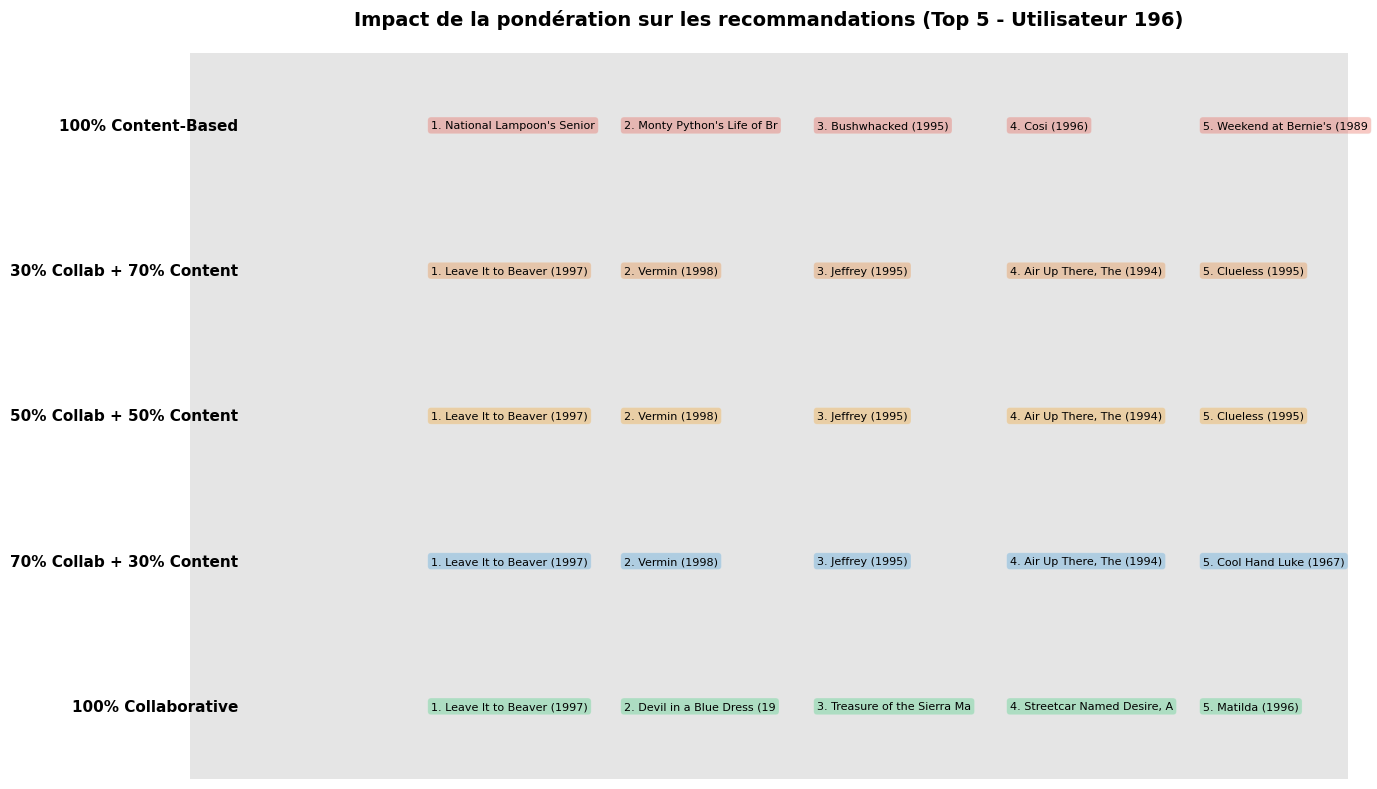


Observations :
- Plus on monte (alpha élevé), plus on favorise le Collaborative
- Plus on descend (alpha bas), plus on favorise le Content-Based
- Les configurations intermédiaires (0.3-0.7) donnent des résultats mixtes


In [15]:
# Tester plusieurs alpha values
alphas = [0.0, 0.3, 0.5, 0.7, 1.0]
results_by_alpha = {}

for alpha in alphas:
    beta = 1.0 - alpha
    recs = get_hybrid_recommendations(
        user_id, svd_model, ratings, movies, cosine_sim,
        alpha=alpha, beta=beta, n=5
    )
    results_by_alpha[alpha] = recs[['title', 'hybrid_score']].values

# Créer un graphique plus lisible
fig, ax = plt.subplots(figsize=(14, 8))

y_positions = {0.0: 4, 0.3: 3, 0.5: 2, 0.7: 1, 1.0: 0}
colors = ['#e74c3c', '#e67e22', '#f39c12', '#3498db', '#2ecc71']

for i, alpha in enumerate(alphas):
    y_pos = y_positions[alpha]
    
    # Label de configuration
    if alpha == 0.0:
        config_label = "100% Content-Based"
    elif alpha == 1.0:
        config_label = "100% Collaborative"
    else:
        config_label = f"{int(alpha*100)}% Collab + {int((1-alpha)*100)}% Content"
    
    ax.text(-0.15, y_pos, config_label, fontsize=11, fontweight='bold', 
            ha='right', va='center')
    
    # Top 5 films
    for j, (title, score) in enumerate(results_by_alpha[alpha]):
        ax.text(j*0.2 + 0.05, y_pos, f"{j+1}. {title[:25]}", 
                fontsize=8, ha='left', va='center',
                bbox=dict(boxstyle='round,pad=0.3', 
                         facecolor=colors[i], alpha=0.3))

ax.set_xlim(-0.2, 1.0)
ax.set_ylim(-0.5, 4.5)
ax.set_yticks([])
ax.set_xticks([])
ax.set_title(f'Impact de la pondération sur les recommandations (Top 5 - Utilisateur {user_id})', 
             fontsize=14, fontweight='bold', pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

print("\nObservations :")
print("- Plus on monte (alpha élevé), plus on favorise le Collaborative")
print("- Plus on descend (alpha bas), plus on favorise le Content-Based")
print("- Les configurations intermédiaires (0.3-0.7) donnent des résultats mixtes")

## 6. Choisir la Meilleure Pondération

Pour choisir la meilleure pondération (α et β), on peut :

1. **Tester avec plusieurs utilisateurs** pour voir quelle configuration donne les meilleurs résultats en moyenne
2. **Utiliser des métriques d'évaluation** (on fera ça dans le Notebook 5)
3. **Permettre à chaque utilisateur de choisir** sa préférence (plus de découverte vs plus de similarité)

Pour l'instant, on va utiliser **α=0.7, β=0.3** comme configuration par défaut.
Cela favorise le Collaborative (découverte) tout en gardant un peu de Content-Based (sécurité).

In [16]:
def recommend_hybrid(user_id, svd_model, ratings_df, movies_df, cosine_sim, 
                     n=10, alpha=0.7):
    """
    Fonction finale pour générer des recommandations hybrides
    
    Paramètres :
    - user_id : ID de l'utilisateur
    - svd_model : Modèle SVD
    - ratings_df : DataFrame des ratings
    - movies_df : DataFrame des films
    - cosine_sim : Matrice de similarité
    - n : Nombre de recommandations
    - alpha : Poids du Collaborative (par défaut 0.7)
    
    Retourne : DataFrame avec les recommandations
    """
    beta = 1.0 - alpha
    
    recommendations = get_hybrid_recommendations(
        user_id, svd_model, ratings_df, movies_df, cosine_sim,
        alpha=alpha, beta=beta, n=n
    )
    
    return recommendations[['item_id', 'title', 'year', 'genres', 'hybrid_score']]

print("Fonction finale de recommandation créée")

Fonction finale de recommandation créée


In [17]:
# Tester avec 3 utilisateurs différents
test_users = [50, 196, 300]

for user_id in test_users:
    print(f"\n{'='*80}")
    print(f"RECOMMANDATIONS HYBRIDES - Utilisateur {user_id}")
    print(f"{'='*80}\n")
    
    recs = recommend_hybrid(user_id, svd_model, ratings, movies, cosine_sim, n=5)
    print(recs[['title', 'genres', 'hybrid_score']].to_string(index=False))


RECOMMANDATIONS HYBRIDES - Utilisateur 50

                                                     title genres  hybrid_score
               My Life as a Dog (Mitt liv som hund) (1985)  Drama           1.0
                                  Washington Square (1997)  Drama           1.0
                    One Flew Over the Cuckoo's Nest (1975)  Drama           1.0
Horseman on the Roof, The (Hussard sur le toit, Le) (1995)  Drama           1.0
                              To Kill a Mockingbird (1962)  Drama           1.0

RECOMMANDATIONS HYBRIDES - Utilisateur 196

                    title       genres  hybrid_score
Leave It to Beaver (1997)       Comedy      1.000000
            Vermin (1998)       Comedy      0.997417
           Jeffrey (1995)       Comedy      0.961325
 Air Up There, The (1994)       Comedy      0.959491
    Cool Hand Luke (1967) Comedy|Drama      0.914747

RECOMMANDATIONS HYBRIDES - Utilisateur 300

                       title        genres  hybrid_score
           

## 7. Sauvegarde du Système Hybride

Nous sauvegardons une configuration complète du système hybride pour pouvoir l'utiliser facilement plus tard.

In [18]:
import pickle
import os

# Créer le dossier models s'il n'existe pas
os.makedirs('../models', exist_ok=True)

# Sauvegarder la configuration hybride
hybrid_config = {
    'alpha': 0.7,
    'beta': 0.3,
    'description': 'Configuration hybride par défaut : 70% Collaborative + 30% Content-Based'
}

with open('../models/hybrid_config.pkl', 'wb') as f:
    pickle.dump(hybrid_config, f)

print("Configuration hybride sauvegardée")
print(f"Alpha (Collaborative) : {hybrid_config['alpha']}")
print(f"Beta (Content-Based) : {hybrid_config['beta']}")

Configuration hybride sauvegardée
Alpha (Collaborative) : 0.7
Beta (Content-Based) : 0.3


## Résumé du Notebook 4

### Ce qu'on a appris :

1. **Systèmes Hybrides** : Combinent plusieurs approches de recommandation
2. **Normalisation** : Nécessaire pour combiner des scores de différentes échelles
3. **Pondération** : α et β permettent de contrôler l'influence de chaque approche
4. **Trade-off** : Plus de Collaborative = plus de découverte, plus de Content-Based = plus de sécurité

### Résultats obtenus :

- Fonction de recommandation hybride fonctionnelle
- Tests avec différentes pondérations (0% à 100%)
- Configuration par défaut : 70% Collaborative + 30% Content-Based

### Observations :

- **100% Collaborative** : Recommande des films très différents basés sur d'autres utilisateurs
- **100% Content-Based** : Recommande des films très similaires aux goûts actuels
- **Configurations mixtes (30%-70%)** : Donnent des résultats très similaires et équilibrés
- **Le choix de α** dépend de l'objectif :
  - α élevé (0.7-0.9) : Plus de découverte, prendre des risques
  - α moyen (0.4-0.6) : Équilibre
  - α bas (0.1-0.3) : Rester dans la zone de confort

### Avantages du système hybride :

- Combine les forces des deux approches
- Plus robuste (si une approche échoue, l'autre compense)
- Réduit le cold start pour les nouveaux films
- Meilleure diversité dans les recommandations

### Prochaine étape :

Dans le Notebook 5, nous allons **évaluer** les trois approches (Collaborative seul, Content-Based seul, Hybrid) avec des métriques précises :
- Precision@K
- Recall@K
- NDCG
- MAP